In [2]:
import pandas as pd

# Load the provided dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/electricity/MBC GO Energy Consumption Milestone 2.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure and contents
data.head()


,Account,Date,year,month,day,Channel,Units,0:00,1:00,2:00,...,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00,day_energy,SUM
0,6930212101,"Monday, January 1, 2018",2018,1,1,Fahren,Fahren,-5.80,1.40,1.40,...,1.40,-0.40,1.40,-4.00,-5.80,-5.80,-4.00,-5.80,-33.00,NaN
1,6930212101,"Monday, January 1, 2018",2018,1,1,RH,RH,91.58,91.87,91.87,...,64.92,64.66,70.89,70.21,76.61,76.61,70.21,76.61,1915.27,NaN
2,6930212101,"Monday, January 1, 2018",2018,1,1,104895486 1,kWh,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN
3,6930212101,"Monday, January 1, 2018",2018,1,1,104895486 2,kVARh,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN
4,6930212101,"Monday, January 1, 2018",2018,1,1,106119542 1 kWh,kWh,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN


In [3]:
from pandas import to_datetime

# Convert 'Date' column to datetime format
data['Date'] = to_datetime(data['Date'], errors='coerce')

# Filter the data to focus on daily energy consumption ('day_energy')
# Assuming 'day_energy' is the total energy consumption per day
energy_data = data[['Date', 'day_energy']].dropna()

# Group the data by Date and sum up the energy consumption for each day
daily_energy = energy_data.groupby('Date').sum().reset_index()

# Display the processed data
daily_energy.head()


,Date,day_energy
0,2018-01-01,164413.500335
1,2018-01-02,209268.639003
2,2018-01-03,216594.323670
3,2018-01-04,217612.647716
4,2018-01-05,209309.055064


In [4]:
import numpy as np

# Check for missing dates in the sequence
expected_dates = pd.date_range(start=daily_energy['Date'].min(), end=daily_energy['Date'].max())
missing_dates = expected_dates.difference(daily_energy['Date'])

# Display missing dates, if any
missing_dates_list = missing_dates.to_list()
missing_dates_list


[]

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Feature Engineering: Add day of the week as a feature
daily_energy['day_of_week'] = daily_energy['Date'].dt.dayofweek

# Data Normalization
scaler = MinMaxScaler()
daily_energy['scaled_energy'] = scaler.fit_transform(daily_energy[['day_energy']])

# Preparing Time Series Sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    for i in range(len(data) - n_past - n_future + 1):
        X.append(data[i:(i + n_past), 0])
        y.append(data[(i + n_past):(i + n_past + n_future), 0])
    return np.array(X), np.array(y)

# Number of past days to use for predicting the future
n_past = 30
# Number of future days to predict
n_future = 7
# Prepare input and output sequences
X, y = create_sequences(daily_energy[['scaled_energy']].values, n_past, n_future)

# Display the shape of the prepared data
X.shape, y.shape


((339, 30), (339, 7))

In [6]:
!pip install tensorflow

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Model Building: LSTM network
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_past, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(n_future)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 7)                 357       
                                                                 
Total params: 30957 (120.93 KB)
Trainable params: 30957 (120.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# After finding the optimal learning rate
optimal_lr = 1e-6  # Replace with the value you found to be optimal
optimizer = tf.keras.optimizers.SGD(learning_rate=optimal_lr, momentum=0.9)

# Recompile the model with the optimal learning rate
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Retrain the model with both input features (X) and target values (y)
history = model.fit(X, y, epochs=100, batch_size=32)  # Adjust epochs and batch_size as needed


Epoch 1/100
11/11 [==============================] - 3s 30ms/step - loss: 0.1964
Epoch 2/100
11/11 [==============================] - 0s 30ms/step - loss: 0.1963
Epoch 3/100
11/11 [==============================] - 0s 30ms/step - loss: 0.1963
Epoch 4/100
11/11 [==============================] - 0s 31ms/step - loss: 0.1961
Epoch 5/100
11/11 [==============================] - 0s 30ms/step - loss: 0.1963
Epoch 6/100
11/11 [==============================] - 0s 29ms/step - loss: 0.1962
Epoch 7/100
11/11 [==============================] - 0s 31ms/step - loss: 0.1963
Epoch 8/100
11/11 [==============================] - 0s 30ms/step - loss: 0.1961
Epoch 9/100
11/11 [==============================] - 0s 30ms/step - loss: 0.1963
Epoch 10/100
11/11 [==============================] - 0s 31ms/step - loss: 0.1964
Epoch 11/100
11/11 [==============================] - 0s 30ms/step - loss: 0.1963
Epoch 12/100
11/11 [==============================] - 0s 34ms/step - loss: 0.1960
Epoch 13/100
11/11 [=====

1/1 [==============================] - 0s 27ms/step


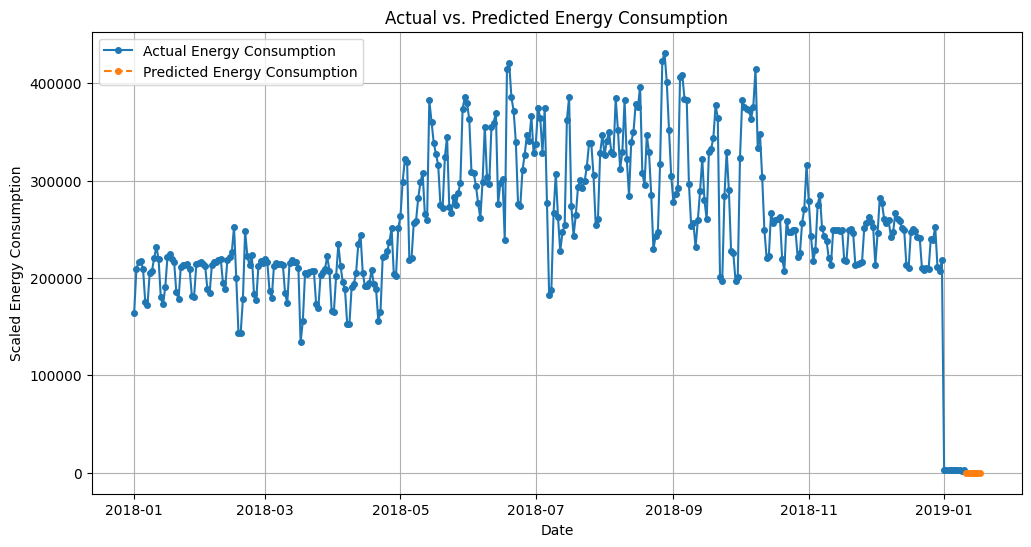

In [26]:
# Import library yang dibutuhkan
import numpy as np
import matplotlib.pyplot as plt

# Jumlah hari yang ingin diprediksi ke depan (1 minggu)
days_to_predict = 7

# Ambil data terakhir dari X sebagai seed untuk prediksi pertama
seed_data = X[-1:]

# Inisialisasi array untuk menyimpan hasil prediksi
predicted_energy = []

# Melakukan prediksi untuk setiap hari
for _ in range(days_to_predict):
    # Prediksi energi untuk hari berikutnya
    prediction = model.predict(seed_data.reshape(1, n_past, 1))

    # Menambahkan hasil prediksi ke dalam array
    predicted_energy.append(prediction[0, -1])  # Mengambil hasil prediksi untuk hari terakhir

    # Memperbarui data seed untuk prediksi berikutnya (mengganti hari terakhir dengan hasil prediksi)
    seed_data = np.roll(seed_data, shift=-1, axis=1)
    seed_data[0, -1] = prediction[0, 0]  # Mengganti hari terakhir dengan hasil prediksi

# Mengubah hasil prediksi ke dalam bentuk array numpy
predicted_energy = np.array(predicted_energy)

# Menghitung tanggal untuk hasil prediksi
last_date = daily_energy['Date'].max()
predicted_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict)

# Visualisasi hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(daily_energy['Date'], daily_energy['day_energy'], label='Actual Energy Consumption', marker='o', markersize=4)
plt.plot(predicted_dates, predicted_energy, label='Predicted Energy Consumption', linestyle='--', marker='o', markersize=4)
plt.xlabel('Date')
plt.ylabel('Scaled Energy Consumption')
plt.title('Actual vs. Predicted Energy Consumption')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Mengubah hasil prediksi ke dalam skala asli (inverse scaling)
predicted_energy_actual_scale = scaler.inverse_transform(predicted_energy.reshape(-1, 1))

# Mengambil data aktual untuk hari yang ingin diprediksi
actual_energy = daily_energy['day_energy'].tail(days_to_predict).values

# Menghitung MAE dan RMSE
mae = mean_absolute_error(actual_energy, predicted_energy_actual_scale)
rmse = np.sqrt(mean_squared_error(actual_energy, predicted_energy_actual_scale))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')


MAE: 995.81
RMSE: 1035.78


In [31]:
# Simpan model dalam format SavedModel
model.save('saved_model/my_model')

# Konversi model ke format tf-lite dengan ops Select TF
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

# Simpan model tf-lite ke dalam file
with open('/mnt/data/my_model.tflite', 'wb') as f:
    f.write(tflite_model)


FileNotFoundError: ignored

FileNotFoundError: ignored